# Instacart Market Basket Analysis — Feature Extraction & Modelling

This notebook extracts features for predicting product reorders using XGBoost and produces a Kaggle submission file.

**Pipeline Overview:**
1. Load pre-processed Parquet files from the data engineering layer
2. Build four feature groups (product, user, user-product, recent) — all from the **prior orders only**
3. preparing training and test datasets with no data leakage
4. i trained XGBoost with a user-level validation split
5. Generate and save the final submission

**Key Decisions:**
- All features are derived exclusively from `eval_set == 'prior'` data — train and test orders never included in features
- Negatives are constructed from prior user-product history (hard negatives only) to avoid implicit signal from the train basket
- Validation is performed at the **user level** so no user's rows straddle both folds
- The prediction threshold is locked from the validation set F1 curve and applied unchanged to the test set

## Importing Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import joblib
from pathlib import Path

import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# defining Paths and directories
PROJECT_ROOT = Path(os.path.abspath(".."))
INTERIM_DIR  = PROJECT_ROOT / "data" / "interim"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
parquet_dir  = PROCESSED_DIR   # alias used throughout

print("Setup complete!")
print(f"  INTERIM_DIR  : {INTERIM_DIR}")
print(f"  PROCESSED_DIR: {PROCESSED_DIR}")

Setup complete!
  INTERIM_DIR  : /Users/pattern115/Desktop/instacart-retail-project-clean/data/interim
  PROCESSED_DIR: /Users/pattern115/Desktop/instacart-retail-project-clean/data/processed


## Loading the Data

All source files were produced by the data engineering layer and are stored as Parquet for efficient columnar access.

| File | Contents |
|---|---|
| `orders.parquet` | All orders with `eval_set` (prior / train / test) |
| `fact_order_items.parquet` | All purchased items, prior + train combined |
| `dim_products.parquet` | Product catalogue with aisle and department |

We split `fact_order_items` into prior and train subsets using the `eval_set` flag on `orders`.

In [2]:
print("Loading datasets from Parquet\n")

dim_products = pd.read_parquet(PROCESSED_DIR / "dim_products.parquet")
orders = pd.read_parquet(INTERIM_DIR   / "orders.parquet")
fact_order_items = pd.read_parquet(PROCESSED_DIR / "fact_order_items.parquet")

# I am Splitting into prior / train subsets based on 'eval_set' in orders
prior_order_ids = orders[orders['eval_set'] == 'prior']['order_id'].unique()
order_products_prior = fact_order_items[
    fact_order_items['order_id'].isin(prior_order_ids)
].copy()

train_order_ids = orders[orders['eval_set'] == 'train']['order_id'].unique()
order_products_train = fact_order_items[
    fact_order_items['order_id'].isin(train_order_ids)
].copy()

print("Dataset shapes:")
print(f"  orders               : {orders.shape}")
print(f"  order_products_prior : {order_products_prior.shape}")
print(f"  order_products_train : {order_products_train.shape}")
print(f"  dim_products         : {dim_products.shape}")

display(orders.head(3))

Loading datasets from Parquet

Dataset shapes:
  orders               : (3421083, 7)
  order_products_prior : (32434489, 4)
  order_products_train : (1384617, 4)
  dim_products         : (49688, 6)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,-1.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


## Building the Base DataFrame (Prior Orders Only)

In [3]:
# Join order-item rows with order metadata and product catalogue.
# I restricted to eval_set == 'prior' explicitly so that even if upstream data changes
# no train transactions can enter the feature pipeline.

prior_df = (
    order_products_prior
    .merge(orders, on='order_id', how='inner')
    .merge(
        dim_products[['product_id', 'product_name', 'aisle_id', 'department_id']],
        on='product_id', how='inner'
    )
)

# filtering — ensuring only prior rows exist even if merge semantics change
prior_df = prior_df[prior_df['eval_set'] == 'prior'].copy()

print(f"prior_df shape : {prior_df.shape}")
print(f"Memory usage   : {prior_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"Unique users   : {prior_df['user_id'].nunique():,}")
print(f"Unique products: {prior_df['product_id'].nunique():,}")
display(prior_df.head(3))

prior_df shape : (32434489, 13)
Memory usage   : 4154.0 MB
Unique users   : 206,209
Unique products: 49,677


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13


## Feature Engineering

Four feature groups are created, all computed **exclusively from prior-order history**:

| Group | Key Features |
|---|---|
| **Product** | Total orders, reorder rate, avg cart position, unique buyers |
| **User** | Order count, avg days between orders, basket size, reorder ratio |
| **User-Product** | How many times the user bought this item, their personal reorder rate, recency |
| **Recent** | Binary flags — was this product in the user's last 1 / 2 / 3 orders? |

### Product Features

In [4]:
def create_product_features(prior_df):
    """
    Aggregate statistics for each product across all prior purchases.

    Returns one row per product_id.
    """
    print("Creating product features")

    product_features = prior_df.groupby('product_id').agg(
        product_total_orders   = ('order_id', 'count'),
        product_total_reorders = ('reordered', 'sum'),
        product_avg_cart_pos   = ('add_to_cart_order', 'mean'),
    ).reset_index()

    # Reorder probability = fraction of appearances that were reorders
    product_features['product_reorder_probability'] = (
        product_features['product_total_reorders'] /
        product_features['product_total_orders']
    )

    # Counting the distinct buyers
    product_unique_users = (
        prior_df.groupby('product_id')['user_id']
        .nunique()
        .reset_index()
        .rename(columns={'user_id': 'product_unique_users'})
    )
    product_features = product_features.merge(product_unique_users, on='product_id')

    print(f"  Product features shape: {product_features.shape}")
    return product_features


product_features = create_product_features(prior_df)
display(product_features.head())
print("\nDescriptive statistics:")
display(product_features.describe().round(3))

product_features.to_parquet(parquet_dir / 'product_features.parquet',
                            index=False, compression='snappy')
print("Saved to product_features.parquet")

Creating product features
  Product features shape: (49677, 6)


,product_id,product_total_orders,product_total_reorders,product_avg_cart_pos,product_reorder_probability,product_unique_users
0,1,1852,1136,5.801836,0.613391,716
1,2,90,12,9.888889,0.133333,78
2,3,277,203,6.415162,0.732852,74
3,4,329,147,9.507599,0.446809,182
4,5,15,9,6.466667,0.600000,6



Descriptive statistics:


,product_id,product_total_orders,product_total_reorders,product_avg_cart_pos,product_reorder_probability,product_unique_users
count,49677.000,49677.000,49677.000,49677.000,49677.000,49677.000
mean,24843.417,652.908,385.018,9.098,0.366,267.890
std,14343.035,4792.114,3601.714,2.551,0.208,1308.789
min,1.000,1.000,0.000,1.000,0.000,1.000
25%,12423.000,17.000,4.000,7.626,0.208,11.000
50%,24842.000,60.000,22.000,9.057,0.377,35.000
75%,37264.000,260.000,115.000,10.356,0.529,137.000
max,49688.000,472565.000,398609.000,53.000,0.941,73956.000


Saved to product_features.parquet


### User Features

In [5]:
def create_user_features(prior_df, orders):
    """
    Aggregate statistics describing each user's shopping behaviour.

    Returns one row per user_id.
    """
    print("Creating user features")

    user_orders = orders[orders['eval_set'] == 'prior'].copy()

    # Order-level aggregations
    user_order_stats = user_orders.groupby('user_id').agg(
        user_total_orders            = ('order_id', 'count'),
        user_avg_days_between_orders = ('days_since_prior_order', 'mean'),
        user_std_days_between_orders = ('days_since_prior_order', 'std'),
    ).reset_index()
    user_order_stats['user_std_days_between_orders'].fillna(0, inplace=True)

    # Item-level aggregations
    user_item_stats = prior_df.groupby('user_id').agg(
        user_total_products  = ('product_id', 'count'),
        user_unique_products = ('product_id', 'nunique'),
        user_total_reorders  = ('reordered', 'sum'),
    ).reset_index()

    user_features = user_order_stats.merge(user_item_stats, on='user_id')

    # Deriving the ratios of reorders and average basket size
    user_features['user_reorder_ratio'] = (
        user_features['user_total_reorders'] /
        user_features['user_total_products']
    )
    user_features['user_avg_basket_size'] = (
        user_features['user_total_products'] /
        user_features['user_total_orders']
    )

    print(f"  User features shape: {user_features.shape}")
    return user_features


user_features = create_user_features(prior_df, orders)
display(user_features.head())
print("\nDescriptive statistics:")
display(user_features.describe().round(3))

user_features.to_parquet(parquet_dir / 'user_features.parquet',
                         index=False, compression='snappy')
print("Saving to user_features.parquet")

Creating user features


/var/folders/3p/6zxdcgj90s7bmtk42756500c0000gp/T/ipykernel_78934/3915605633.py:17: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  user_order_stats['user_std_days_between_orders'].fillna(0, inplace=True)


  User features shape: (206209, 9)


,user_id,user_total_orders,user_avg_days_between_orders,user_std_days_between_orders,user_total_products,user_unique_products,user_total_reorders,user_reorder_ratio,user_avg_basket_size
0,1,10,17.500000,10.987366,59,18,41,0.694915,5.900000
1,2,14,14.071429,10.425297,195,102,93,0.476923,13.928571
2,3,12,11.000000,6.367531,88,33,55,0.625000,7.333333
3,4,5,10.800000,10.545141,18,17,1,0.055556,3.600000
4,5,4,9.750000,8.220908,37,23,14,0.378378,9.250000



Descriptive statistics:


,user_id,user_total_orders,user_avg_days_between_orders,user_std_days_between_orders,user_total_products,user_unique_products,user_total_reorders,user_reorder_ratio,user_avg_basket_size
count,206209.000,206209.000,206209.000,206209.000,206209.000,206209.000,206209.000,206209.000,206209.000
mean,103105.000,15.590,12.670,9.773,157.289,64.536,92.753,0.432,9.952
std,59527.555,16.655,5.350,3.919,204.208,56.592,158.400,0.212,5.864
min,1.000,3.000,-0.333,0.408,3.000,1.000,0.000,0.000,1.000
25%,51553.000,5.000,8.385,6.820,39.000,25.000,10.000,0.268,5.741
50%,103105.000,9.000,12.478,9.983,83.000,48.000,33.000,0.429,8.933
75%,154657.000,19.000,16.812,12.528,188.000,86.000,101.000,0.596,13.000
max,206209.000,99.000,26.818,17.898,3725.000,726.000,3275.000,0.990,70.250


Saving to user_features.parquet


### User-Product Features

In [6]:
def create_user_product_features(prior_df):
    """
    Creating the interaction history between each user and each product
    across all their prior orders.

    Returns one row per (user_id, product_id) pair.
    """
    print("Creating user-product features")

    up = prior_df.groupby(['user_id', 'product_id']).agg(
        up_total_orders    = ('order_id', 'count'),
        up_total_reorders  = ('reordered', 'sum'),
        up_avg_cart_pos    = ('add_to_cart_order', 'mean'),
        up_last_order_num  = ('order_number', 'max'),
    ).reset_index()

    up['up_reorder_ratio'] = up['up_total_reorders'] / up['up_total_orders']

    # How many orders have passed since the user last bought this product?
    user_max_order = (
        prior_df.groupby('user_id')['order_number']
        .max()
        .reset_index()
        .rename(columns={'order_number': 'user_max_order_number'})
    )
    up = up.merge(user_max_order, on='user_id')
    up['up_orders_since_last'] = up['user_max_order_number'] - up['up_last_order_num']
    up.drop(columns='user_max_order_number', inplace=True)

    print(f"  User-product features shape: {up.shape}")
    return up


user_product_features = create_user_product_features(prior_df)
display(user_product_features.head())
print("\nDescriptive statistics:")
display(user_product_features.describe().round(3))

user_product_features.to_parquet(parquet_dir / 'user_product_features.parquet',
                                 index=False, compression='snappy')
print("Saving to user_product_features.parquet")

Creating user-product features
  User-product features shape: (13307953, 8)


,user_id,product_id,up_total_orders,up_total_reorders,up_avg_cart_pos,up_last_order_num,up_reorder_ratio,up_orders_since_last
0,1,196,10,9,1.400000,10,0.900000,0
1,1,10258,9,8,3.333333,10,0.888889,0
2,1,10326,1,0,5.000000,5,0.000000,5
3,1,12427,10,9,3.300000,10,0.900000,0
4,1,13032,3,2,6.333333,10,0.666667,0



Descriptive statistics:


,user_id,product_id,up_total_orders,up_total_reorders,up_avg_cart_pos,up_last_order_num,up_reorder_ratio,up_orders_since_last
count,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07
mean,1.029987e+05,2.551351e+04,2.437000e+00,1.437000e+00,9.217000e+00,1.586700e+01,2.660000e-01,9.513000e+00
std,5.943677e+04,1.422429e+04,3.555000e+00,3.555000e+00,6.984000e+00,1.730300e+01,3.400000e-01,1.341700e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,5.157900e+04,1.329200e+04,1.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,0.000000e+00,1.000000e+00
50%,1.027130e+05,2.564000e+04,1.000000e+00,0.000000e+00,7.500000e+00,9.000000e+00,0.000000e+00,4.000000e+00
75%,1.544500e+05,3.815700e+04,2.000000e+00,1.000000e+00,1.200000e+01,2.100000e+01,5.000000e-01,1.200000e+01
max,2.062090e+05,4.968800e+04,9.900000e+01,9.800000e+01,1.450000e+02,9.900000e+01,9.900000e-01,9.800000e+01


Saving to user_product_features.parquet


### Recent Order Features (Last N Orders)

In [7]:
def create_recent_order_features(prior_df, n_recent=3):
    """
    Binary flags indicating whether each user-product pair appeared in
    each of the user's last n_recent prior orders.

    'Last 1' = most recent prior order; 'Last 3' = three orders ago.
    Recency is computed within the prior sequence only — the train order
    is never referenced.
    """
    print(f"Creating recent order features (last {n_recent} orders)")

    user_max_order = (
        prior_df.groupby('user_id')['order_number']
        .max()
        .reset_index()
        .rename(columns={'order_number': 'max_order_number'})
    )
    prior_with_max = prior_df.merge(user_max_order, on='user_id')
    prior_with_max['orders_ago'] = (
        prior_with_max['max_order_number'] - prior_with_max['order_number']
    )

    recent_features = None
    for i in range(n_recent):
        order_i = (
            prior_with_max[prior_with_max['orders_ago'] == i]
            [['user_id', 'product_id']]
            .drop_duplicates()
            .copy()
        )
        order_i[f'in_order_last_{i+1}'] = 1

        if recent_features is None:
            recent_features = order_i
        else:
            recent_features = recent_features.merge(
                order_i, on=['user_id', 'product_id'], how='outer'
            )

    for i in range(n_recent):
        recent_features[f'in_order_last_{i+1}'].fillna(0, inplace=True)

    print(f"  Recent features shape: {recent_features.shape}")
    return recent_features


recent_features = create_recent_order_features(prior_df, n_recent=3)
display(recent_features.head())
for i in range(1, 4):
    n = int(recent_features[f'in_order_last_{i}'].sum())
    print(f"  Products in last-{i} order: {n:,}")

recent_features.to_parquet(parquet_dir / 'recent_features.parquet',
                           index=False, compression='snappy')
print("Saving to recent_features.parquet")

Creating recent order features (last 3 orders)
  Recent features shape: (4925215, 5)


/var/folders/3p/6zxdcgj90s7bmtk42756500c0000gp/T/ipykernel_78934/2596199197.py:41: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  recent_features[f'in_order_last_{i+1}'].fillna(0, inplace=True)


,user_id,product_id,in_order_last_1,in_order_last_2,in_order_last_3
0,1,196,1.0,1.0,1.0
1,1,10258,1.0,1.0,1.0
2,1,12427,1.0,1.0,1.0
3,1,13032,1.0,NaN,NaN
4,1,25133,1.0,1.0,1.0


  Products in last-1 order: 2,139,788
  Products in last-2 order: 2,114,926
  Products in last-3 order: 2,094,487
Saving to recent_features.parquet


##  Preparing the Training Dataset

**Target variable:** `reordered = 1` if the user bought this product again in their train order; `0` otherwise.

**Sample construction:**
- *Positives* — products with `reordered == 1` in `order_products_train`
- *Hard negatives* — products the user bought in prior orders but did **not** buy in their train order; sampled at a 5:1 ratio to positives
- sampled at 5:1 means that for every positive example (a product that was reordered in the train order), we will include up to 5 hard negative examples (products that the user bought in the prior orders but did not reorder in the train order). This helps to create a more balanced training dataset while still focusing on the most relevant negative examples, which can improve the model's ability to distinguish between products that are likely to be reordered and those that are not, without overwhelming the model with too many negative examples that may be less informative.

> **Note on "easy negatives":** Earlier versions of this notebook included items that appeared in the train basket for the first time (`reordered == 0`). These were removed because they carry implicit information about what was in the train order, which cannot be replicated at inference time and creates a subtle training/inference mismatch.

In [8]:
def create_training_dataset(orders, order_products_train, user_features,
                             product_features, user_product_features,
                             recent_features, neg_ratio=5, random_state=42):
    """
    Build the labelled training dataset by joining positives and hard negatives
    with the four prior-only feature tables.

    Args:
        neg_ratio : number of hard negatives to sample per positive (default 5)
    """
    print("Creating training dataset")

    train_orders = orders[orders['eval_set'] == 'train'][['order_id', 'user_id']]
    train_users  = train_orders['user_id'].unique()

    # Positives: products actually reordered in the train basket
    positives = (
        order_products_train
        .merge(train_orders, on='order_id', how='inner')
        [['user_id', 'product_id']]
    )
    positives = positives.drop_duplicates()
    positives['reordered'] = 1
    print(f"  Positives : {len(positives):,}")

    # Hard negatives: prior products NOT bought in train
    # Source: user_product_features contains exactly the (user, product) pairs
    # from prior orders — no train data ever enters this table.
    prior_pairs = (
        user_product_features[['user_id', 'product_id']]
        .drop_duplicates()
    )
    candidates = prior_pairs[prior_pairs['user_id'].isin(train_users)]

    train_bought = positives[['user_id', 'product_id']].drop_duplicates()
    hard_negatives = candidates.merge(
        train_bought, on=['user_id', 'product_id'], how='left', indicator=True
    )
    hard_negatives = (
        hard_negatives[hard_negatives['_merge'] == 'left_only']
        .drop(columns='_merge')
    )
    hard_negatives['reordered'] = 0

    # Sample to control class ratio it means we won't use all hard negatives if they are too many compared to positives
    n_neg = min(len(hard_negatives), len(positives) * neg_ratio)
    hard_negatives = hard_negatives.sample(n=n_neg, random_state=random_state)
    print(f"  Hard negatives (sampled {neg_ratio}:1): {len(hard_negatives):,}")

    # Combining and attaching the features for positives and hard negatives
    train_data = pd.concat(
        [positives[['user_id', 'product_id', 'reordered']],
         hard_negatives[['user_id', 'product_id', 'reordered']]],
        ignore_index=True
    )

    train_data = (
        train_data
        .merge(user_features,         on='user_id',                how='left')
        .merge(product_features,      on='product_id',             how='left')
        .merge(user_product_features, on=['user_id', 'product_id'], how='left')
        .merge(recent_features,       on=['user_id', 'product_id'], how='left')
    )
    train_data.fillna(0, inplace=True)

    reorder_rate = train_data['reordered'].mean()
    print(f"  Final shape   : {train_data.shape}")
    print(f"  Reorder rate  : {reorder_rate:.1%}  "
          f"({'realistic' if 0.10 <= reorder_rate <= 0.30 else 'check sampling'})")
    return train_data


train_dataset = create_training_dataset(
    orders, order_products_train,
    user_features, product_features, user_product_features, recent_features
)
display(train_dataset.head(3))

train_dataset.to_parquet(parquet_dir / 'train_dataset.parquet',
                         index=False, compression='snappy')
size_mb = os.path.getsize(parquet_dir / 'train_dataset.parquet') / 1024**2
print(f"Saving train_dataset.parquet  ({size_mb:.1f} MB)")

Creating training dataset
  Positives : 1,384,617
  Hard negatives (sampled 5:1): 6,923,085
  Final shape   : (8307702, 25)
  Reorder rate  : 16.7%  (realistic)


,user_id,product_id,reordered,user_total_orders,user_avg_days_between_orders,user_std_days_between_orders,user_total_products,user_unique_products,user_total_reorders,user_reorder_ratio,user_avg_basket_size,product_total_orders,product_total_reorders,product_avg_cart_pos,product_reorder_probability,product_unique_users,up_total_orders,up_total_reorders,up_avg_cart_pos,up_last_order_num,up_reorder_ratio,up_orders_since_last,in_order_last_1,in_order_last_2,in_order_last_3
0,112108,49302,1,3,7.0,8.0,21,12,9,0.428571,7.0,163.0,101.0,6.392638,0.619632,62.0,2.0,1.0,2.5,2.0,0.5,1.0,0.0,1.0,1.0
1,112108,11109,1,3,7.0,8.0,21,12,9,0.428571,7.0,4472.0,3192.0,7.385957,0.713775,1280.0,2.0,1.0,4.0,2.0,0.5,1.0,0.0,1.0,1.0
2,112108,10246,1,3,7.0,8.0,21,12,9,0.428571,7.0,23826.0,12498.0,9.608327,0.524553,11328.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Saving train_dataset.parquet  (237.8 MB)


### Training Dataset Sanity Checks

In [9]:
print("TRAINING DATASET SANITY CHECKS")

# 1. Target distribution 
reorder_rate = train_dataset['reordered'].mean()
pos = int(train_dataset['reordered'].sum())
total = len(train_dataset)
print(f"\nTarget distribution:")
print(f"  Positive (reordered=1): {pos:,}  ({pos/total:.1%})")
print(f"  Negative (reordered=0): {total-pos:,}  ({(total-pos)/total:.1%})")
if not (0.08 <= reorder_rate <= 0.35):
    print("Reorder rate outside expected 8-35% range — review sampling")
else:
    print("Reorder rate looks realistic")

# 2. Confirming that no order_id from train leaked into user_product_features
train_order_ids_set = set(
    orders[orders['eval_set'] == 'train']['order_id'].unique()
)
if 'order_id' in user_product_features.columns:
    leaked = user_product_features['order_id'].isin(train_order_ids_set).any()
    print(f"\nTrain order IDs in user_product_features: {'YES — leakage!' if leaked else 'None'}")
else:
    print("\nuser_product_features has no order_id column has no leakage vector")

# 3. up_orders_since_last should be >= 0
min_recency = train_dataset['up_orders_since_last'].min()
print(f"\nMin up_orders_since_last : {min_recency}  "
      f"({'OK' if min_recency >= 0 else 'negative values found'})")

# 4. Recent features are binary
for col in ['in_order_last_1', 'in_order_last_2', 'in_order_last_3']:
    vals = set(train_dataset[col].unique())
    status = '✓' if vals <= {0, 1, 0.0, 1.0} else 'non-binary values'
    print(f"  {col}: values = {sorted(vals)[:4]}  {status}")

# 5. Missing values
missing = train_dataset.isna().sum()
if missing.max() > 0:
    print("\nMissing values detected:")
    print(missing[missing > 0])
else:
    print("\nNo missing values")

print("All checks passed — proceed to modelling")

TRAINING DATASET SANITY CHECKS

Target distribution:
  Positive (reordered=1): 1,384,617  (16.7%)
  Negative (reordered=0): 6,923,085  (83.3%)
Reorder rate looks realistic

user_product_features has no order_id column has no leakage vector

Min up_orders_since_last : 0.0  (OK)
  in_order_last_1: values = [np.float64(0.0), np.float64(1.0)]  ✓
  in_order_last_2: values = [np.float64(0.0), np.float64(1.0)]  ✓
  in_order_last_3: values = [np.float64(0.0), np.float64(1.0)]  ✓

No missing values
All checks passed — proceed to modelling


## preparing Test Dataset

Test candidates are every product each test-set user purchased in their **prior orders**.
We attach the same four feature tables used for training — all prior-only, no target column.

In [10]:
def create_test_dataset(orders, user_features, product_features,
                         user_product_features, recent_features):
    """
    Building the unlabelled test dataset for prediction.

    Candidates for each test user = all products they bought in prior orders.
    """
    print("Creating test dataset")

    test_orders = orders[orders['eval_set'] == 'test'][['order_id', 'user_id']]
    print(f"  Test orders: {len(test_orders):,}")

    # All products a test user has bought in prior orders
    prior_pairs = user_product_features[['user_id', 'product_id']].drop_duplicates()
    test_candidates = test_orders.merge(prior_pairs, on='user_id', how='inner')
    print(f"  Candidate (user, product) pairs: {len(test_candidates):,}")

    test_data = (
        test_candidates
        .merge(user_features,         on='user_id',                how='left')
        .merge(product_features,      on='product_id',             how='left')
        .merge(user_product_features, on=['user_id', 'product_id'], how='left')
        .merge(recent_features,       on=['user_id', 'product_id'], how='left')
    )
    test_data.fillna(0, inplace=True)

    print(f"  Test dataset shape: {test_data.shape}")
    return test_data


test_dataset = create_test_dataset(
    orders, user_features, product_features, user_product_features, recent_features
)
display(test_dataset.head(3))

test_dataset.to_parquet(parquet_dir / 'test_dataset.parquet',
                        index=False, compression='snappy')
size_mb = os.path.getsize(parquet_dir / 'test_dataset.parquet') / 1024**2
print(f"Saving to test_dataset.parquet  ({size_mb:.1f} MB)")

Creating test dataset
  Test orders: 75,000
  Candidate (user, product) pairs: 4,833,292
  Test dataset shape: (4833292, 25)


,order_id,user_id,product_id,user_total_orders,user_avg_days_between_orders,user_std_days_between_orders,user_total_products,user_unique_products,user_total_reorders,user_reorder_ratio,user_avg_basket_size,product_total_orders,product_total_reorders,product_avg_cart_pos,product_reorder_probability,product_unique_users,up_total_orders,up_total_reorders,up_avg_cart_pos,up_last_order_num,up_reorder_ratio,up_orders_since_last,in_order_last_1,in_order_last_2,in_order_last_3
0,2774568,3,248,12,11.0,6.367531,88,33,55,0.625,7.333333,6371,2550,10.620782,0.400251,3821,1,0,3.000000,2,0.000000,10,0.0,0.0,0.0
1,2774568,3,1005,12,11.0,6.367531,88,33,55,0.625,7.333333,463,204,9.498920,0.440605,259,1,0,5.000000,10,0.000000,2,0.0,0.0,1.0
2,2774568,3,1819,12,11.0,6.367531,88,33,55,0.625,7.333333,2424,1193,9.287541,0.492162,1231,3,2,2.666667,7,0.666667,5,0.0,0.0,0.0


Saving to test_dataset.parquet  (79.4 MB)


## Model Training

**Validation strategy — user-level split:**  
We assign entire users to either the training fold or the validation fold.  
This prevents a single user's rows from appearing in both folds, giving an honest estimate of out-of-sample performance on new users.

**Why not a random row split?**  
A random row split lets the same user's data appear in both folds. Because user-level features (`user_total_orders`, `user_reorder_ratio`, etc.) are shared across all of a user's rows, the model can exploit in-fold knowledge of those users when evaluated on the validation set — inflating measured performance.

In [11]:
print("Starting XGBoost modelling\n")

# Loading training data
train = pd.read_parquet(parquet_dir / 'train_dataset.parquet')

EXCLUDE = ['user_id', 'product_id', 'reordered']
feature_cols = [c for c in train.columns if c not in EXCLUDE]

X = train[feature_cols]
y = train['reordered']
users = train['user_id']

print(f"Features : {X.shape[1]}")
print(f"Rows     : {X.shape[0]:,}")
print(f"Feature list: {feature_cols}")

del train
gc.collect()

# User-level train / validation split
# I am using 15% of users (not rows) so no user's rows straddle both folds.
# This is important to prevent data leakage since the same user appearing in both train and val would make the task easier and not reflect real-world performance.
rng = np.random.default_rng(42)
unique_users = users.unique()
val_users = set(rng.choice(unique_users, size=int(len(unique_users) * 0.15), replace=False))

val_mask   = users.isin(val_users)
train_mask = ~val_mask

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]

print(f"\nTrain fold : {X_train.shape[0]:,} rows  ({train_mask.sum() / len(X):.1%}) "
      f"from {(~val_mask & users.isin(unique_users)).sum() // X_train.shape[0] if X_train.shape[0] > 0 else '?'}"
      f"~{len(unique_users) - len(val_users):,} users")
print(f"Val fold   : {X_val.shape[0]:,} rows  ({val_mask.sum()   / len(X):.1%}) "
      f"from {len(val_users):,} users")
print("(User-level split — no user straddles both folds)")

# XGBoost parameters
params = dict(
    objective        = 'binary:logistic',  # binary classification (predicting probabilities of reorder)
    eval_metric      = ['auc', 'aucpr'],   # aucpr is more informative for imbalanced targets 
    tree_method      = 'hist', # fast histogram-based algorithm suitable for large datasets
    device           = 'cpu', 
    random_state     = 42, # for reproducibility
    n_estimators     = 500, # larger budget; early stopping will find the right count
    learning_rate    = 0.05,
    max_depth        = 6, # reduced from 7 to limit overfitting
    min_child_weight = 5, # child weight is the minimum sum of instance weight needed in a child; higher values can prevent overfitting
    subsample        = 0.8, # row sampling to prevent overfitting
    colsample_bytree = 0.8, # feature sampling to prevent overfitting
    gamma            = 0.1, # minimum loss reduction required to make a further partition on a leaf node; higher values lead to more conservative models
    reg_lambda       = 1.0, 
    reg_alpha        = 0.1,
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
    missing          = np.nan,
    early_stopping_rounds = 30, # stopping when val AUC stops improving
)

print("\nTraining XGBoost (early stopping on val AUC)")

model = xgb.XGBClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

print(f"\nBest iteration: {model.best_iteration}")

Starting XGBoost modelling

Features : 22
Rows     : 8,307,702
Feature list: ['user_total_orders', 'user_avg_days_between_orders', 'user_std_days_between_orders', 'user_total_products', 'user_unique_products', 'user_total_reorders', 'user_reorder_ratio', 'user_avg_basket_size', 'product_total_orders', 'product_total_reorders', 'product_avg_cart_pos', 'product_reorder_probability', 'product_unique_users', 'up_total_orders', 'up_total_reorders', 'up_avg_cart_pos', 'up_last_order_num', 'up_reorder_ratio', 'up_orders_since_last', 'in_order_last_1', 'in_order_last_2', 'in_order_last_3']

Train fold : 7,053,536 rows  (84.9%) from 1~111,528 users
Val fold   : 1,254,166 rows  (15.1%) from 19,681 users
(User-level split — no user straddles both folds)

Training XGBoost (early stopping on val AUC)
[0]	validation_0-auc:0.88858	validation_0-aucpr:0.75547
[50]	validation_0-auc:0.89534	validation_0-aucpr:0.76503
[100]	validation_0-auc:0.89677	validation_0-aucpr:0.76756
[150]	validation_0-auc:0.89714

### Validation Evaluation

In [12]:
# Prediction on validation fold
y_val_proba = model.predict_proba(X_val)[:, 1]

# Default threshold for a quick read
y_val_pred_default = (y_val_proba >= 0.5).astype(int)

print("VALIDATION METRICS (threshold = 0.50)")
print(f"  F1        : {f1_score(y_val, y_val_pred_default):.4f}")
print(f"  Precision : {precision_score(y_val, y_val_pred_default):.4f}")
print(f"  Recall    : {recall_score(y_val, y_val_pred_default):.4f}")
print(f"  ROC AUC   : {roc_auc_score(y_val, y_val_proba):.4f}")

VALIDATION METRICS (threshold = 0.50)
  F1        : 0.6177
  Precision : 0.5169
  Recall    : 0.7673
  ROC AUC   : 0.8978


### Threshold Selection (Validation Set Only)

The prediction threshold is chosen by scanning F1 scores on the **validation fold only**.  
This threshold is then applied unchanged to the test set — we do **not** adjust it by inspecting test-set basket statistics (None rate, average size, etc.), which would constitute test-set leakage.

Best threshold (val F1): 0.50
  Val F1        : 0.6177
  Val Precision : 0.5169
  Val Recall    : 0.7673


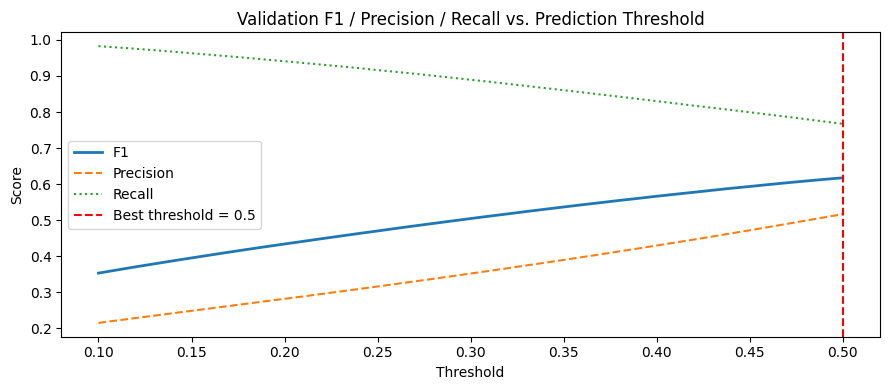


Threshold locked at 0.50 — this value is used for the test submission without modification.


In [13]:
# Scan thresholds on validation folds
thresholds = np.arange(0.10, 0.51, 0.01)
results = []

for th in thresholds:
    pred = (y_val_proba >= th).astype(int)
    results.append({
        'threshold' : round(th, 2),
        'f1'        : f1_score(y_val, pred),
        'precision' : precision_score(y_val, pred),
        'recall'    : recall_score(y_val, pred),
    })

results_df = pd.DataFrame(results)
best_row   = results_df.loc[results_df['f1'].idxmax()]
BEST_THRESHOLD = best_row['threshold']

print(f"Best threshold (val F1): {BEST_THRESHOLD:.2f}")
print(f"  Val F1        : {best_row['f1']:.4f}")
print(f"  Val Precision : {best_row['precision']:.4f}")
print(f"  Val Recall    : {best_row['recall']:.4f}")

# Plotting F1 vs threshold
plt.figure(figsize=(9, 4))
plt.plot(results_df['threshold'], results_df['f1'],        label='F1',        lw=2)
plt.plot(results_df['threshold'], results_df['precision'], label='Precision', lw=1.5, ls='--')
plt.plot(results_df['threshold'], results_df['recall'],    label='Recall',    lw=1.5, ls=':')
plt.axvline(BEST_THRESHOLD, color='red', ls='--', label=f'Best threshold = {BEST_THRESHOLD}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Validation F1 / Precision / Recall vs. Prediction Threshold')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nThreshold locked at {BEST_THRESHOLD:.2f} — this value is used for the test submission without modification.")

### Feature Importance

XGBoost's built-in gain importance is shown for quick reference.
Note that gain can favour high-cardinality features; for more rigorous analysis, SHAP values (`pip install shap`) provide model-consistent, per-prediction attributions.

Top 15 features by gain:


,feature,importance
0,up_total_orders,0.240858
1,up_orders_since_last,0.238607
2,in_order_last_1,0.153277
3,in_order_last_2,0.104149
4,up_reorder_ratio,0.084736
5,in_order_last_3,0.054248
6,up_total_reorders,0.032952
7,up_avg_cart_pos,0.032189
8,product_reorder_probability,0.013075
9,user_total_orders,0.012905


<Figure size 1000x700 with 0 Axes>

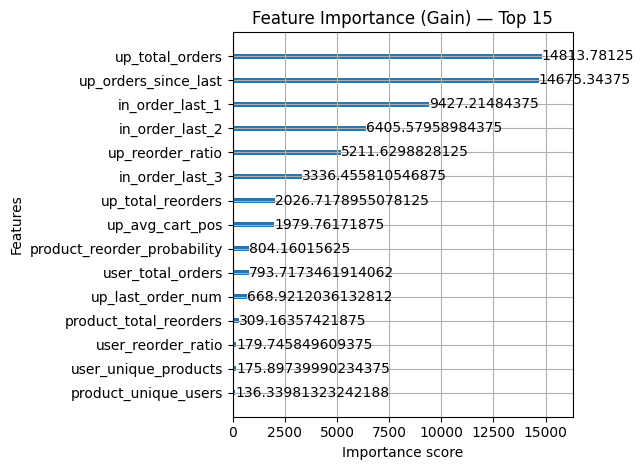

In [14]:
importance_df = (
    pd.DataFrame({'feature': feature_cols,
                  'importance': model.feature_importances_})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print("Top 15 features by gain:")
display(importance_df.head(15))

plt.figure(figsize=(10, 7))
xgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.title("Feature Importance (Gain) — Top 15")
plt.tight_layout()
plt.show()

In [15]:
# Saving model in both formats for reproducibility
model_json_path = parquet_dir / 'xgboost_instacart_model.json'
model_pkl_path  = parquet_dir / 'xgboost_instacart_model.pkl'

model.save_model(model_json_path)
joblib.dump(model, model_pkl_path)

print(f"Model saved:")
print(f"  JSON   : {model_json_path}")
print(f"  joblib : {model_pkl_path}")

Model saved:
  JSON   : /Users/pattern115/Desktop/instacart-retail-project-clean/data/processed/xgboost_instacart_model.json
  joblib : /Users/pattern115/Desktop/instacart-retail-project-clean/data/processed/xgboost_instacart_model.pkl


### Generating prediction
I applied `BEST_THRESHOLD` (derived from the validation F1 curve above) to the test set predictions.

The threshold is **not** re-tuned using test-set statistics such as None rate or average basket size — doing so would leak information about the test distribution into the submission strategy.

In [16]:
print("Generating test predictions\n")

# Loading the test dataset
test = pd.read_parquet(parquet_dir / 'test_dataset.parquet')

# Ensure order_id is present (it is included by create_test_dataset)
if 'order_id' not in test.columns:
    test_orders_map = orders[orders['eval_set'] == 'test'][['order_id', 'user_id']]
    test = test.merge(test_orders_map, on='user_id', how='left')

# Predicting reorder probabilities
exclude_test = ['order_id', 'user_id', 'product_id']
test_feature_cols = [c for c in test.columns if c not in exclude_test]
X_test = test[test_feature_cols]

test['reordered_proba'] = model.predict_proba(X_test)[:, 1]
print(f"Predictions complete — {len(test):,} (user, product) pairs scored")

# Applying validation-derived threshold
# BEST_THRESHOLD was selected solely on the validation fold above.
print(f"Applying threshold: {BEST_THRESHOLD:.2f}  (from validation F1 optimisation)")

test['predicted'] = (test['reordered_proba'] >= BEST_THRESHOLD).astype(int)

# Format prediction
def format_basket(group):
    products = group[group['predicted'] == 1]['product_id'].astype(str).tolist()
    return ' '.join(products) if products else 'None'

prediction = (
    test.groupby('order_id')
    .apply(format_basket)
    .reset_index()
    .rename(columns={0: 'products'})
)

print(f"\nPrediction shape: {prediction.shape}")
display(prediction.head(10))

none_rate  = (prediction['products'] == 'None').mean()
avg_size   = prediction['products'].apply(
    lambda x: len(x.split()) if x != 'None' else 0
).mean()
print(f"\nNone rate        : {none_rate:.1%}")
print(f"Avg basket size  : {avg_size:.1f} products")

# Saving prediction
prediction_path = parquet_dir / 'instacart_prediction.csv'
prediction.to_csv(prediction_path, index=False)
print(f"\nPrediction saved {prediction_path}")

Generating test predictions

Predictions complete — 4,833,292 (user, product) pairs scored
Applying threshold: 0.50  (from validation F1 optimisation)

Prediction shape: (75000, 2)


,order_id,products
0,17,13107 21463 21709 21903 38777 39275 47766
1,34,2596 13176 16083 21137 39180 39475 43504 44632...
2,137,2326 5134 23794 24852 25890 29594 38689 41787
3,182,5479 9337 11520 13629 16973 31737 32109 33000 ...
4,257,1025 4605 11140 12456 13870 21137 22035 24838 ...
5,313,12779 13198 14077 21903 25890 28535 30391 3496...
6,353,15541 21137 33000 35561 40688 48183
7,386,260 1158 2326 4920 6046 8174 10343 15872 16797...
8,414,4472 7539 14947 19006 20392 20564 21230 21376 ...
9,418,1503 5262 12036 13702 30489 38694 40268 41950 ...



None rate        : 1.7%
Avg basket size  : 12.3 products

Prediction saved /Users/pattern115/Desktop/instacart-retail-project-clean/data/processed/instacart_prediction.csv


### prediction Diagnostics

Basket size distribution:
count    75000.00
mean        12.27
std         10.17
min          0.00
25%          5.00
50%         10.00
75%         17.00
max        100.00
Name: products, dtype: float64

Quantiles:
0.10     2.0
0.25     5.0
0.50    10.0
0.75    17.0
0.90    26.0
0.95    33.0
0.99    47.0
Name: products, dtype: float64

  Empty baskets (None) : 1.7%
  1-5 items            : 26.9%
  > 20 items           : 17.1%


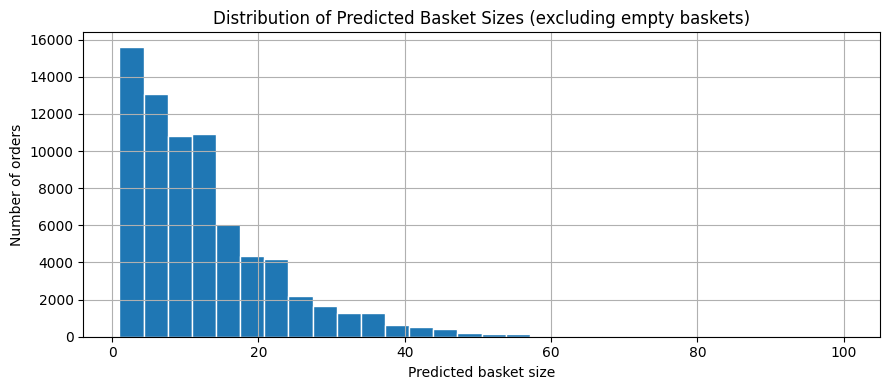

In [17]:
# Basket size distribution — for review only, not used to alter the threshold
basket_sizes = prediction['products'].apply(
    lambda x: len(x.split()) if x != 'None' else 0
)

print("Basket size distribution:")
print(basket_sizes.describe().round(2))
print()
print("Quantiles:")
print(basket_sizes.quantile([0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).round(1))
print()
print(f"  Empty baskets (None) : {(basket_sizes == 0).mean():.1%}")
print(f"  1-5 items            : {((basket_sizes >= 1) & (basket_sizes <= 5)).mean():.1%}")
print(f"  > 20 items           : {(basket_sizes > 20).mean():.1%}")

plt.figure(figsize=(9, 4))
basket_sizes[basket_sizes > 0].hist(bins=30, edgecolor='white')
plt.xlabel('Predicted basket size')
plt.ylabel('Number of orders')
plt.title('Distribution of Predicted Basket Sizes (excluding empty baskets)')
plt.tight_layout()
plt.show()

### Readable predictions(Product IDs → Names)

In [18]:
# Map product IDs back to names for easy manual inspection
id_to_name = dict(zip(
    dim_products['product_id'].astype(str),
    dim_products['product_name']
))

def ids_to_names(product_string):
    if product_string == 'None' or pd.isna(product_string):
        return 'None'
    return ', '.join(id_to_name.get(pid, f'[{pid}]') for pid in product_string.split())

prediction['product_names'] = prediction['products'].apply(ids_to_names)

print("First 10 orders with readable product names:")
display(prediction[['order_id', 'products', 'product_names']].head(10))

readable_path = parquet_dir / 'instacart_prediction_readable.csv'
prediction.to_csv(readable_path, index=False)
print(f"\nReadable prediction saved  {readable_path}")

First 10 orders with readable product names:


,order_id,products,product_names
0,17,13107 21463 21709 21903 38777 39275 47766,"The Complete Cookie Double Chocolate, Vanilla ..."
1,34,2596 13176 16083 21137 39180 39475 43504 44632...,"Lemon Cake Ice Cream, Bag of Organic Bananas, ..."
2,137,2326 5134 23794 24852 25890 29594 38689 41787,"Organic Blueberry Waffles, Organic Thompson Se..."
3,182,5479 9337 11520 13629 16973 31737 32109 33000 ...,"Italian Sparkling Mineral Water, Purity Farms ..."
4,257,1025 4605 11140 12456 13870 21137 22035 24838 ...,"Organic Fresh Basil, Yellow Onions, Organic Ro..."
5,313,12779 13198 14077 21903 25890 28535 30391 3496...,"Spaghetti Squash, 85% Lean Ground Beef, Homema..."
6,353,15541 21137 33000 35561 40688 48183,"Original Almondmilk, Organic Strawberries, Pur..."
7,386,260 1158 2326 4920 6046 8174 10343 15872 16797...,"Cantaloupe, Mango Chunks, Organic Blueberry Wa..."
8,414,4472 7539 14947 19006 20392 20564 21230 21376 ...,"Toasted Coconut Almondmilk Blend, Organic Chew..."
9,418,1503 5262 12036 13702 30489 38694 40268 41950 ...,"Low Fat Cottage Cheese, Brown Extra Large Grad..."



Readable prediction saved  /Users/pattern115/Desktop/instacart-retail-project-clean/data/processed/instacart_prediction_readable.csv


## 9. Summary

### Files Produced

| File | Description |
|---|---|
| `product_features.parquet` | Product-level aggregate statistics |
| `user_features.parquet` | User-level shopping behaviour features |
| `user_product_features.parquet` | Per (user, product) interaction history |
| `recent_features.parquet` | Binary recency flags for last 3 orders |
| `train_dataset.parquet` | Labelled training set (positives + hard negatives) |
| `test_dataset.parquet` | Unlabelled test set for prediction |
| `xgboost_instacart_model.json` | Trained XGBoost model (portable JSON) |
| `xgboost_instacart_model.pkl` | Trained XGBoost model (joblib pickle) |
| `instacart_prediction.csv` | prediction file |
| `instacart_prediction_readable.csv` | prediction with product names appended |

### Key Design Decisions & Methodology Notes

**No data leakage:**  
All four feature tables are derived exclusively from `eval_set == 'prior'` transactions.
A defensive `eval_set == 'prior'` filter is applied to `prior_df` before any aggregation, and no `order_id` from the train or test set ever enters the feature tables.

**Hard negatives only (no easy negatives):**  
Easy negatives (first-time purchases in the train basket, `reordered == 0`) were excluded because they implicitly reveal what was in the train order. Only hard negatives — prior-history products the user did not reorder — are used, sampled at a 5:1 ratio.

**User-level validation split:**  
Validation users are held out as complete groups so no user's rows straddle both folds, providing an unbiased estimate of out-of-sample performance on new users.

**Threshold from validation only:**  
The prediction threshold is selected by maximising F1 on the validation fold and applied unchanged to the test set. Test-set statistics (None rate, basket size) are shown as diagnostics only and do not influence the threshold.

In [19]:
print("Produced Parquet / CSV files:\n")
all_outputs = list(parquet_dir.glob('*.parquet')) + list(parquet_dir.glob('*.csv'))
for f in sorted(all_outputs):
    size = f.stat().st_size / 1024**2
    print(f"  {f.name:<45} {size:6.1f} MB")

Produced Parquet / CSV files:

  association_rules_fp_0.csv                       0.0 MB
  dim_products.parquet                             1.5 MB
  fact_order_items.parquet                       117.2 MB
  instacart_prediction.csv                         5.7 MB
  instacart_prediction_readable.csv               28.9 MB
  instacart_submission.csv                         5.7 MB
  instacart_submission_readable.csv               28.9 MB
  product_features.parquet                         1.0 MB
  product_prices.parquet                           0.3 MB
  recent_features.parquet                         13.4 MB
  submission_adaptive_p70.csv                      8.7 MB
  submission_adaptive_p75.csv                      7.4 MB
  submission_adaptive_p80.csv                      6.1 MB
  submission_adaptive_p85.csv                      4.7 MB
  submission_adaptive_p90.csv                      3.4 MB
  submission_top10_min0.24.csv                     4.5 MB
  submission_top11_min0.22.csv           